In [24]:
import numpy as np
import tensorflow as tf
import IPython
import time
import matplotlib.pyplot as plt
import functools
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from jupyterthemes import jtplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
jtplot.style()

# Data vizualisation and processing
**Use GPU if possible** 


In [25]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data loading

**Loading X_train**

In [26]:
Y_train = pd.read_csv('Y_train_surge.csv')
Y_train = Y_train.to_numpy()
surge_input = Y_train[:,1:21]

data = np.load("X_train_surge_new.npz")
slp = data["slp"] #the 40 sea-level pressure (SLP) fields, encoded in images of size (41, 41).
surge1_input= data["surge1_input"] #the given surge heights in city 1.
surge2_input = data["surge2_input"] #the given surge heights in city 2.
#t_surge1_output = data["t_surge1_output"] #the 10 GMT times at which we must predict surge heights in city 1.
#t_surge2_output = data["t_surge2_output"] #the 10 GMT times at which we must predict surge heights in city 2.
# id_sequence = data["id_sequence"] #the ids of the sequence
# t_slp = data["t_slp"]  #the 40 GMT times at which the sea-level pressure (SLP) fields are given.
#t_surge2_input = data["t_surge2_input"] #the 10 GMT times at which the surge heights are given in city 2.
# t_surge1_input = data["t_surge1_input"] #the 10 GMT times at which the surge heights are given in city 1

In [23]:
print(np.amin(surge_input))
print(np.amin(surge1_input))
print(np.amin(surge2_input))

-6.256784336331415
-2.9692142
-6.2567844


**Loading X_test**

In [27]:
data_test = np.load("X_test_surge_new.npz")
slp_test =  data_test["slp"]

In [6]:
print(slp_test.shape)

(509, 40, 41, 41)


## Some sample of SLP

[12  5 21  5]


<Figure size 460.8x403.2 with 0 Axes>

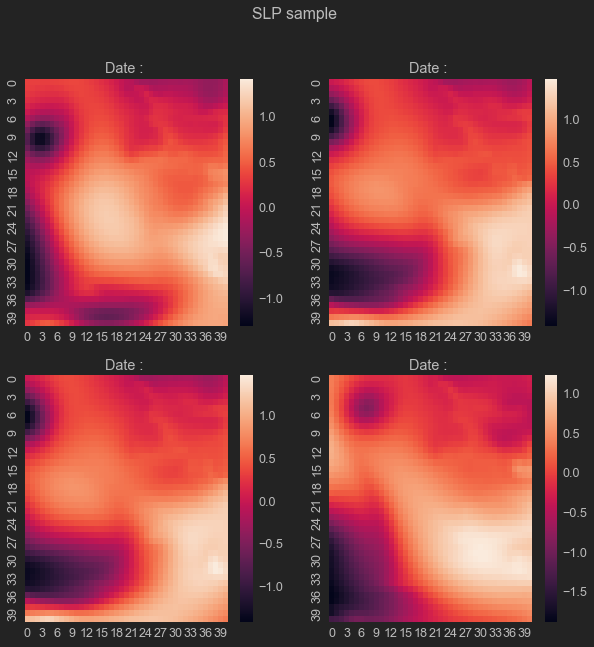

In [119]:
plt.figure()
line = 98
random_inds = np.random.choice(slp.shape[1],4)
print(random_inds)
fig, axes = plt.subplots(2,2,figsize = (10,10))
fig.suptitle('SLP sample')
for i in range(2):
    for j in range(2):
        image_ind = random_inds[i+j]
        sns.heatmap(ax = axes[i,j], data = slp[line,image_ind,:,:]).set(title='Date : ')

## Some sample of surge

[4522 1876 3788 3414]


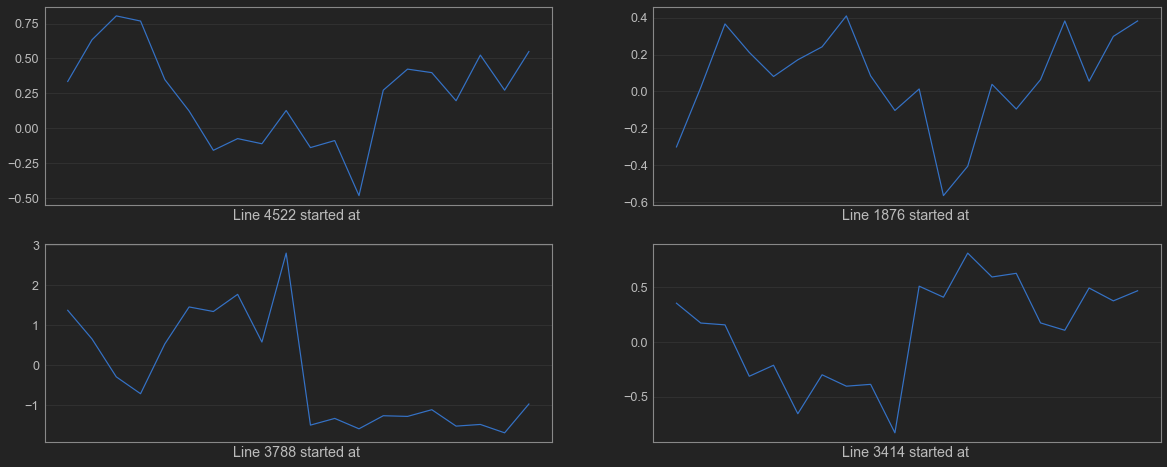

In [29]:
plt.figure(figsize=(20,8))
random_inds = np.random.choice(surge_input.shape[0],4)
print(random_inds)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    image_ind = random_inds[i]
    plt.plot(surge_input[image_ind,:])
    plt.xlabel('Line '+ str(image_ind)+ ' started at ')

# Goal

Given sea level pressure (slp) fields (every 3h during 5 days) and the surge ( 2 times per day during 5 days) , we should forecast surge of the next five days given the slp. 

# Data pre-processing and splitting

## Normalization

In [30]:
### SLP ###
mean_slp = np.mean(slp)
std_slp = np.std(slp)
slp = (slp-mean_slp)/std_slp
slp_test = (slp_test-mean_slp)/std_slp

#### SURGE #####
mean_surge = np.mean(surge_input)
std_surge = np.std(surge_input)
surge_input = (surge_input-mean_surge)/std_surge

In [10]:
print(slp.shape)

(5599, 40, 41, 41)


## Splitting

In [31]:
np.random.seed(0)
## indexes for train and test set
train_set_idx = np.random.choice(slp.shape[0],int(slp.shape[0]*0.8),replace = False)
test_set_idx = np.delete(np.arange(slp.shape[0]),train_set_idx)

## TRAIN SET
train_slp = np.concatenate([np.reshape(slp[i,:,:,:],(1,40,41,41,1)) for i in train_set_idx])
train_surge = np.concatenate([np.reshape(surge_input[i,:],(1,20)) for i in train_set_idx]) # for the first town

### TEST SET
test_slp = np.concatenate([np.reshape(slp[i,:,:,:],(1,40,41,41,1)) for i in test_set_idx])
test_surge = np.concatenate([np.reshape(surge_input[i,:],(1,20)) for i in test_set_idx]) # for the first town


print(train_slp.shape)
print(train_surge.shape)

(4479, 40, 41, 41, 1)
(4479, 20)


In [12]:
print(np.amax(train_surge))

6.935888439342472


# Averaging slp

In [66]:
def data_per_day(train_slp, train_surge = np.zeros(1)):
    x_train = np.concatenate([np.reshape(np.mean(train_slp[0,j*8:8*(j+1):2],axis=0),(1,41,41,1))for j in range(5)],axis=0)
    y_train = None
    
    for i in tqdm(range(1,train_slp.shape[0])):
        #input per day
        x_inter =np.concatenate([np.reshape(np.mean(train_slp[i,j*8:8*(j+1):2],axis=0),(1,41,41,1))\
                                 for j in range(5)],axis=0)
        x_train = np.concatenate((x_train,x_inter),axis=0)
    
    if train_surge.any():
        y1_train = np.concatenate([np.reshape(train_surge[0,j*2:2*(j+1)],(1,2)) for j in range(5)],axis = 0)
        y2_train = np.concatenate([np.reshape(train_surge[0,(j+5)*2:2*(j+6)],(1,2)) for j in range(5)],axis = 0)
        
        for i in tqdm(range(1,train_slp.shape[0])):
            # output per day 1rst town
            y1_inter = np.concatenate([np.reshape(train_surge[i,j*2:2*(j+1)],(1,2))\
                                   for j in range(5)],axis = 0)
            y1_train = np.concatenate((y1_train,y1_inter),axis=0)

                # output per day 2nd town
            y2_inter = np.concatenate([np.reshape(train_surge[i,j*2:2*(j+1)],(1,2))\
                                   for j in range(5)],axis = 0)
            y2_train = np.concatenate((y2_train,y2_inter),axis=0)

        y_train = np.concatenate((y1_train,y2_train),axis=1)

        
    return x_train , y_train

In [67]:
def data_per_five_days(y_pred):
    y1_final = np.concatenate([np.reshape(y_pred[j,0:2],(1,2)) for j in range(5)],axis=1)
    y2_final = np.concatenate([np.reshape(y_pred[j,2:4],(1,2)) for j in range(5)],axis=1)
    
    for i in tqdm(range(5,y_pred.shape[0],5)):
        inter1 = np.concatenate([np.reshape(y_pred[j+i,0:2],(1,2)) for j in range(5)],axis=1)
        y1_final = np.concatenate((y1_final,inter1),axis=0)
        
        inter2 = np.concatenate([np.reshape(y_pred[j+i,2:4],(1,2)) for j in range(5)],axis=1)
        y2_final = np.concatenate((y2_final,inter2),axis=0)
    print(np.concatenate((y1_final,y2_final),axis=1).shape)
    
    return np.concatenate((y1_final,y2_final),axis=1)

In [34]:
x_train,y_train = data_per_day(train_slp,train_surge)

100%|███████████████████████████████████████████████████████████████████████████| 4478/4478 [00:00<00:00, 18150.98it/s]


In [35]:
x_test,y_test = data_per_day(test_slp,test_surge)

100%|███████████████████████████████████████████████████████████████████████████| 1119/1119 [00:00<00:00, 19350.42it/s]


In [45]:
print(x_train.shape)

(22395, 41, 41, 1)


# CNN

In [70]:
def build_cnn_model():
  cnn_model = tf.keras.Sequential([
      
        # First convolutional layer
        tf.keras.layers.Conv2D(filters=12,kernel_size=3,activation="relu"), 

        # First max pooling layer
        tf.keras.layers.MaxPool2D(),
      
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(40, activation='relu'),
        tf.keras.layers.Dense(70, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        # output
        tf.keras.layers.Dense(2,activation = None)
  ])
  return cnn_model

In [71]:
model = build_cnn_model()
model.build(input_shape = x_train.shape)
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2), 
              loss='MeanSquaredError',
              metrics=['RootMeanSquaredError'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (22395, 39, 39, 12)       120       
                                                                 
 max_pooling2d_5 (MaxPooling  (22395, 19, 19, 12)      0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (22395, 4332)             0         
                                                                 
 dense_12 (Dense)            (22395, 40)               173320    
                                                                 
 dense_13 (Dense)            (22395, 70)               2870      
                                                                 
 dropout_4 (Dropout)         (22395, 70)               0         
                                                      

In [81]:
##batch size
BATCH_SIZE = 64
EPOCHS = 200
history = model.fit(x=x_train, y=y_train[:,0:2], batch_size= BATCH_SIZE,epochs=EPOCHS)

Epoch 1/200
175/175 [==============================] - 1s 6ms/step - loss: 0.0930 - root_mean_squared_error: 0.3050
Epoch 2/200
175/175 [==============================] - 1s 6ms/step - loss: 0.0932 - root_mean_squared_error: 0.3054
Epoch 3/200
175/175 [==============================] - 1s 6ms/step - loss: 0.0916 - root_mean_squared_error: 0.3026
Epoch 4/200
175/175 [==============================] - 1s 5ms/step - loss: 0.0912 - root_mean_squared_error: 0.3019
Epoch 5/200
175/175 [==============================] - 1s 5ms/step - loss: 0.0917 - root_mean_squared_error: 0.3028
Epoch 6/200
175/175 [==============================] - 1s 5ms/step - loss: 0.0907 - root_mean_squared_error: 0.3012
Epoch 7/200
175/175 [==============================] - 1s 5ms/step - loss: 0.0926 - root_mean_squared_error: 0.3043
Epoch 8/200
175/175 [==============================] - 1s 5ms/step - loss: 0.0903 - root_mean_squared_error: 0.3005
Epoch 9/200
175/175 [==============================] - 1s 6ms/step - los

175/175 [==============================] - 1s 7ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975
Epoch 72/200
175/175 [==============================] - 1s 8ms/step - loss: 0.0875 - root_mean_squared_error: 0.2958
Epoch 73/200
175/175 [==============================] - 1s 7ms/step - loss: 0.0895 - root_mean_squared_error: 0.2992
Epoch 74/200
175/175 [==============================] - 1s 7ms/step - loss: 0.0889 - root_mean_squared_error: 0.2981
Epoch 75/200
175/175 [==============================] - 1s 7ms/step - loss: 0.0870 - root_mean_squared_error: 0.2950
Epoch 76/200
175/175 [==============================] - 1s 7ms/step - loss: 0.0880 - root_mean_squared_error: 0.2967
Epoch 77/200
175/175 [==============================] - 1s 7ms/step - loss: 0.0896 - root_mean_squared_error: 0.2993
Epoch 78/200
175/175 [==============================] - 1s 7ms/step - loss: 0.0873 - root_mean_squared_error: 0.2954
Epoch 79/200
175/175 [==============================] - 1s 7ms/step - loss: 0

In [87]:
x_predict,_ = data_per_day(slp_test)
model.evaluate(x=x_test,y=y_test[:,0:2],batch_size=64)
y_pred1 = model.predict(x_predict,batch_size=64,verbose=1)

100%|███████████████████████████████████████████████████████████████████████████████| 508/508 [00:03<00:00, 145.74it/s]


40/40 [==============================] - 0s 7ms/step


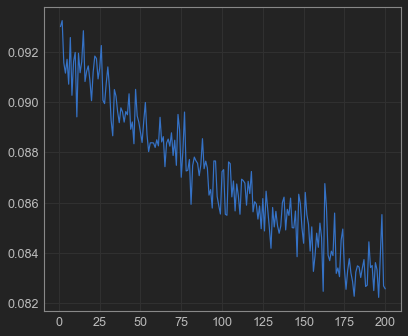

In [83]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),history.history['loss'])

In [84]:
model2 = build_cnn_model()
model2.build(input_shape = x_train.shape)
model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2), 
              loss='MeanSquaredError',
              metrics=['RootMeanSquaredError'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (22395, 39, 39, 12)       120       
                                                                 
 max_pooling2d_6 (MaxPooling  (22395, 19, 19, 12)      0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (22395, 4332)             0         
                                                                 
 dense_15 (Dense)            (22395, 40)               173320    
                                                                 
 dense_16 (Dense)            (22395, 70)               2870      
                                                                 
 dropout_5 (Dropout)         (22395, 70)               0         
                                                      

In [85]:
##batch size
BATCH_SIZE = 64
EPOCHS = 600
history2 = model2.fit(x=x_train, y=y_train[:,2:], batch_size= BATCH_SIZE,epochs=EPOCHS)

Epoch 1/600
350/350 [==============================] - 2s 4ms/step - loss: 0.9263 - root_mean_squared_error: 0.9624
Epoch 2/600
350/350 [==============================] - 1s 4ms/step - loss: 0.9004 - root_mean_squared_error: 0.9489
Epoch 3/600
350/350 [==============================] - 1s 4ms/step - loss: 0.8901 - root_mean_squared_error: 0.9435
Epoch 4/600
350/350 [==============================] - 1s 4ms/step - loss: 0.8821 - root_mean_squared_error: 0.9392
Epoch 5/600
350/350 [==============================] - 2s 5ms/step - loss: 0.8750 - root_mean_squared_error: 0.9354
Epoch 6/600
350/350 [==============================] - 2s 5ms/step - loss: 0.8695 - root_mean_squared_error: 0.9325
Epoch 7/600
350/350 [==============================] - 1s 4ms/step - loss: 0.8666 - root_mean_squared_error: 0.9309
Epoch 8/600
350/350 [==============================] - 2s 4ms/step - loss: 0.8597 - root_mean_squared_error: 0.9272
Epoch 9/600
350/350 [==============================] - 2s 4ms/step - los

350/350 [==============================] - 2s 6ms/step - loss: 0.4931 - root_mean_squared_error: 0.7022
Epoch 72/600
350/350 [==============================] - 2s 6ms/step - loss: 0.4919 - root_mean_squared_error: 0.7014
Epoch 73/600
350/350 [==============================] - 2s 6ms/step - loss: 0.4772 - root_mean_squared_error: 0.6908
Epoch 74/600
350/350 [==============================] - 2s 7ms/step - loss: 0.4744 - root_mean_squared_error: 0.6888
Epoch 75/600
350/350 [==============================] - 2s 6ms/step - loss: 0.4675 - root_mean_squared_error: 0.6837
Epoch 76/600
350/350 [==============================] - 2s 6ms/step - loss: 0.4662 - root_mean_squared_error: 0.6828
Epoch 77/600
350/350 [==============================] - 2s 6ms/step - loss: 0.4609 - root_mean_squared_error: 0.6789
Epoch 78/600
350/350 [==============================] - 2s 6ms/step - loss: 0.4581 - root_mean_squared_error: 0.6768
Epoch 79/600
350/350 [==============================] - 2s 6ms/step - loss: 0

350/350 [==============================] - 2s 6ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521
Epoch 210/600
350/350 [==============================] - 2s 6ms/step - loss: 0.2060 - root_mean_squared_error: 0.4538
Epoch 211/600
350/350 [==============================] - 2s 6ms/step - loss: 0.2030 - root_mean_squared_error: 0.4506
Epoch 212/600
350/350 [==============================] - 2s 6ms/step - loss: 0.2050 - root_mean_squared_error: 0.4527
Epoch 213/600
350/350 [==============================] - 2s 6ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503
Epoch 214/600
350/350 [==============================] - 2s 6ms/step - loss: 0.2055 - root_mean_squared_error: 0.4534
Epoch 215/600
350/350 [==============================] - 2s 7ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
Epoch 216/600
350/350 [==============================] - 2s 7ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486
Epoch 217/600
350/350 [==============================] - 2s 6ms/step -

350/350 [==============================] - 2s 6ms/step - loss: 0.1460 - root_mean_squared_error: 0.3821
Epoch 348/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1398 - root_mean_squared_error: 0.3739
Epoch 349/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1427 - root_mean_squared_error: 0.3777
Epoch 350/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1432 - root_mean_squared_error: 0.3784
Epoch 351/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1412 - root_mean_squared_error: 0.3758
Epoch 352/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1399 - root_mean_squared_error: 0.3740
Epoch 353/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1392 - root_mean_squared_error: 0.3731
Epoch 354/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1388 - root_mean_squared_error: 0.3726
Epoch 355/600
350/350 [==============================] - 2s 6ms/step -

350/350 [==============================] - 2s 6ms/step - loss: 0.1112 - root_mean_squared_error: 0.3335
Epoch 486/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1108 - root_mean_squared_error: 0.3328
Epoch 487/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1116 - root_mean_squared_error: 0.3341
Epoch 488/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1106 - root_mean_squared_error: 0.3326
Epoch 489/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1094 - root_mean_squared_error: 0.3307
Epoch 490/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1100 - root_mean_squared_error: 0.3316
Epoch 491/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1099 - root_mean_squared_error: 0.3315
Epoch 492/600
350/350 [==============================] - 2s 6ms/step - loss: 0.1087 - root_mean_squared_error: 0.3298
Epoch 493/600
350/350 [==============================] - 2s 6ms/step -

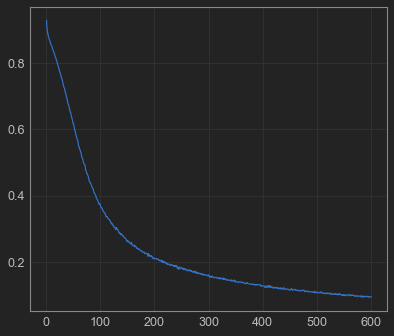

In [86]:
plt.plot(np.linspace(1,EPOCHS,EPOCHS),history2.history['loss'])

In [89]:
model2.evaluate(x=x_test,y=y_test[:,2:],batch_size=64)
y_pred2 = model2.predict(x_predict,batch_size=64,verbose=1)

40/40 [==============================] - 0s 4ms/step


In [90]:
y_pred = np.concatenate((y_pred1,y_pred2),axis=1)
print(y_pred.shape)

(2545, 4)


In [91]:
surge_predicted = data_per_five_days(y_pred)

100%|█████████████████████████████████████████████████████████████████████████████| 508/508 [00:00<00:00, 10803.65it/s]

(509, 20)


In [102]:
surge_predicted = (surge_predicted+mean_surge)*std_surge

In [103]:
print(np.amax(surge_predicted))

4.853663


# FF NN

def build_fcnn_model():
  fcnn_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(250, activation="tanh"),
        tf.keras.layers.Dense(520, activation="sigmoid"),
        tf.keras.layers.Dense(120, activation="tanh"),
        # output
        tf.keras.layers.Dense(4,activation=None)
  ])
  return fcnn_model

model2 = build_fcnn_model()
model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2), 
              loss='MeanSquaredError',
              metrics=['RootMeanSquaredError'])
model2.build(input_shape = x_train.shape)
model2.summary()

##batch size
BATCH_SIZE = 32
EPOCHS = 750
history2 = model2.fit(x=x_train, y=y_train ,validation_data=(x_test,y_test) ,batch_size= BATCH_SIZE,epochs=EPOCHS)

model2.evaluate(x=x_test,y=y_test)

x_predict,_ = data_per_day(slp_test) 
y_pred = model2.predict(x_predict,batch_size=1,verbose=1)

surge_predicted = data_per_five_days(y_pred)

# SVR

SVRs = []
flattened_x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
for i in tqdm(range(y_train.shape[1])):
    SVRs.append(SVR(kernel="rbf", C=10, cache_size=1000))
    SVRs[i].fit(flattened_x_train, y_train[:,i]) 

flattened_x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
SVRs_score = []
for i in tqdm(range(y_train.shape[1])): 
    SVRs_score.append(SVRs[i].score(flattened_x_test,y_test[:,0]))

print(SVRs_score)

x_predict,_ = data_per_day(slp_test)
flattened_x_predict = np.reshape(x_predict,(x_predict.shape[0],x_predict.shape[1]*x_predict.shape[2]))
y_pred = np.concatenate([np.reshape(SVRs[i].predict(flattened_x_predict),(flattened_x_predict.shape[0],1))\
                         for i in range(4)], axis = 1)

print(y_pred.shape)

surge_predicted = data_per_five_days(y_pred)

# Saving in a submission file

In [93]:
print(np.amax(surge_predicted))

4.898345


[358 430 405 332]


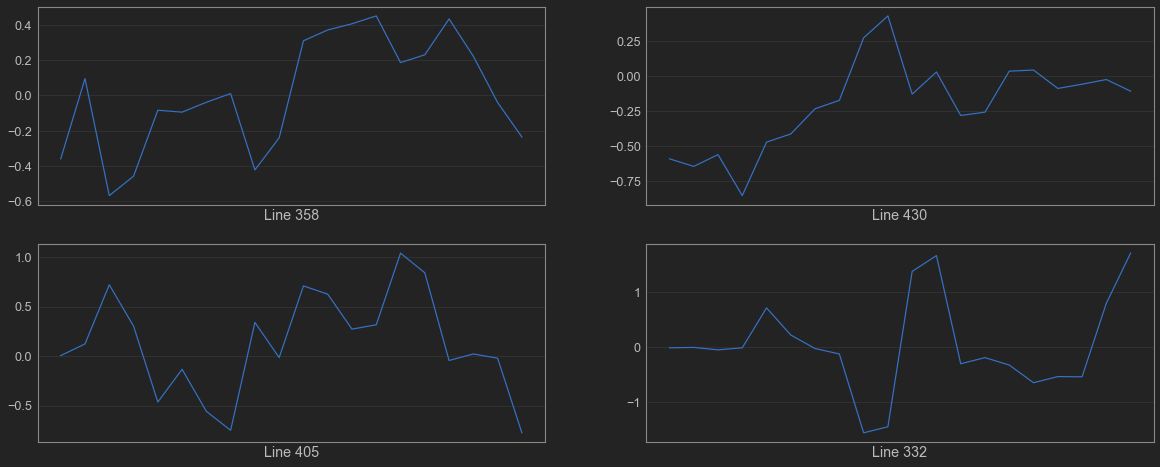

In [104]:
plt.figure(figsize=(20,8))
random_inds = np.random.choice(surge_predicted.shape[0],4)
print(random_inds)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    image_ind = random_inds[i]
    plt.plot(surge_predicted[image_ind,:])
    plt.xlabel('Line '+ str(image_ind))

In [105]:
y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
y_test_benchmark = pd.DataFrame(data=surge_predicted, columns=y_columns, index=data_test['id_sequence'])
y_test_benchmark.to_csv('surge_predicted_CNN.csv', index_label='id_sequence', sep=',')